In [248]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

In [249]:
df = pd.read_csv('stock.csv')

### remove unwanted columns

In [250]:
df = df.drop(['Unnamed: 0', 'open', 'high', 'low', 'volume', 'oi'], 1)

### rename columns as 'ds' and 'y' as Prophet requires this naming convention

In [251]:
df.columns = ['ds', 'y']

### remove the '+05:30' string from the end of dates

In [252]:
df['ds'] = df['ds'].str.replace(r'\+05:30', '')

<ipython-input-252-1a43b65f06ed>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['ds'] = df['ds'].str.replace(r'\+05:30', '')


### convert date column to datetime format

In [253]:
df['ds'] = df['ds'].apply(pd.to_datetime)

### create time series with the missing times

In [254]:
actual = pd.date_range("2021-04-27 13:11", "2021-05-27 16:39", freq="1min")

In [255]:
data = {'ds':actual}
complete_df = pd.DataFrame(data)

In [256]:
full = complete_df.merge(df, on='ds', how='left')

### filling missing times with the previous values

In [257]:
full['y'] = full['y'].fillna(method='ffill')

### Create Prophet model

In [260]:
m = Prophet()
m.fit(full)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Create future dataframe upto 2021-05-27 00:00

In [261]:
future = pd.date_range("2021-05-27 16:40", "2021-05-27 23:59", freq="1min")

In [262]:
data = {'ds':future}
future_df = pd.DataFrame(data)

In [263]:
final_df = pd.concat([df, future_df])

### Generate predictions

In [264]:
forecast = m.predict(final_df)
forecast = forecast[['ds', 'yhat']]
forecast.tail()

,ds,yhat
8414,2021-05-27 23:55:00,1018.920395
8415,2021-05-27 23:56:00,1018.915576
8416,2021-05-27 23:57:00,1018.910929
8417,2021-05-27 23:58:00,1018.906459
8418,2021-05-27 23:59:00,1018.902167


In [265]:
forecasted_final = final_df.merge(forecast)

<AxesSubplot:xlabel='ds'>

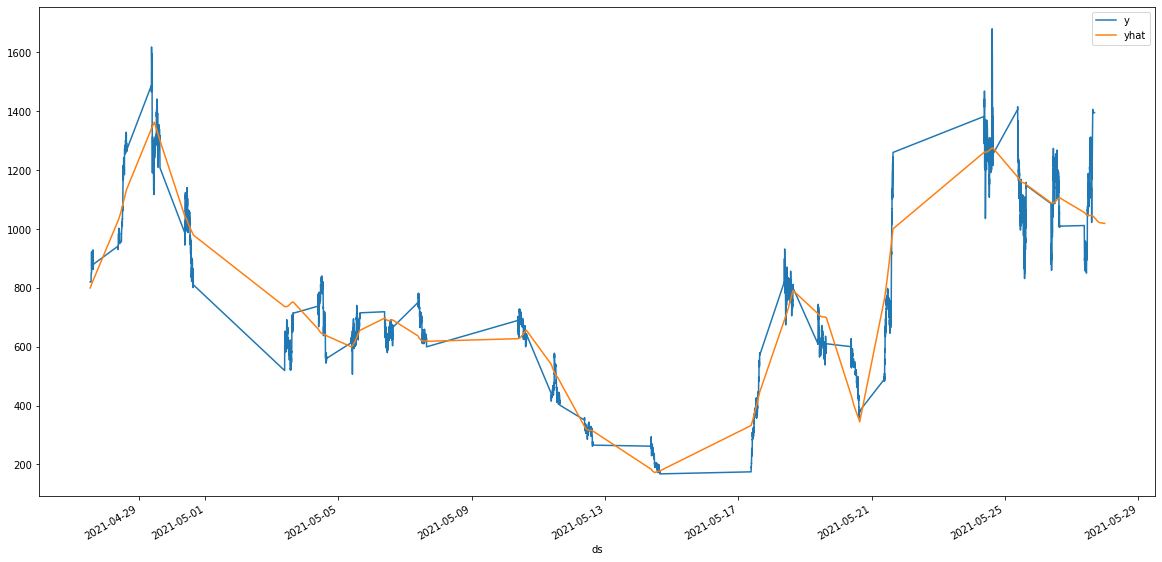

In [266]:
forecasted_final.plot(x='ds', figsize=(20,10))

### Calculate accuracy

In [267]:
forecasted_final['actual_up_trend'] = forecasted_final['y'].pct_change(5)
forecasted_final['foreasted_up_trend'] = forecasted_final['yhat'].pct_change(5)

In [268]:
def f(row):
    if (row['actual_up_trend'] >= 0.03) and (row['foreasted_up_trend'] < 0.03):
        val = 0
    else:
        val = 1
    return val

In [269]:
forecasted_final['accuracy'] = np.nan

### Counting the number of 1 and 0 values

In [270]:
forecasted_final.apply(f, 1).value_counts()

1    7281
0    1138
dtype: int64

In [271]:
7281 / (7281+1138)

0.8648295522033496